---


# **Building kNN and Logistic Regression Classifiers**

---
**Dataset Path:** "Data/stroke.csv"
---

We will deal with the stroke dataset. The dataset contains demographic and health-related data to predict whether a patient is likely to have a stroke.

**Features:**


* id: Unique identifier (can be ignored for modeling).
* gender: Gender of the patient (categorical).
* age: Age of the patient (numerical).
* hypertension: Whether the patient has hypertension (0 = No, 1 = Yes).
* heart_disease: Whether the patient has heart disease (0 = No, 1 = Yes).
* ever_married: Marital status (categorical).
* work_type: Type of work (categorical).
* Residence_type: Rural or Urban (categorical).
* avg_glucose_level: Average glucose level (numerical).
* bmi: Body Mass Index (numerical).
* smoking_status: Smoking habits (categorical).
* stroke: Target variable (1 = Stroke, 0 = No Stroke).

### Feature Definitions:
* Hypertension: commonly known as high blood pressure, it occurs when the pressure in the blood vessels is too high.

# **Necessary Imports**

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
import seaborn as sn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

# **Necessary Functions**

In [ ]:
# Display the outliers of the numerical feature of a dataset
#dataframe: The dataframe to be used
#type_dataset: the name of the dataset, since there are some different datasets in this assignment, to be used in the print function
#return the fence of the outliers after calculating them
def display_outliers_numerical_features(dataframe: pd.DataFrame, type_dataset: str) -> dict:
    numerical_features = dataframe.select_dtypes(include=["float64"]).columns.to_list()
    fence_feature_dict = {}
    for feature in numerical_features:
        fence_feature_dict[feature] = [calculate_fence(dataframe, feature, 1.5), calculate_fence(dataframe, feature, 3)]
        print("Mild Outliers of \"" + feature+ "\" from the", type_dataset, "dataset:")
        print(dataframe[(dataframe[feature] < fence_feature_dict[feature][0][0]) | (dataframe[feature] > fence_feature_dict[feature][0][1])].shape[0])
        print("Extreme outliers of \"" + feature + "\" from the", type_dataset, "dataset:")
        print(dataframe[(dataframe[feature] < fence_feature_dict[feature][1][0]) | (dataframe[feature] > fence_feature_dict[feature][1][1])].shape[0])
    return fence_feature_dict

#Calculte the outer or inner fences for outlier identification
#dataframe: The dataframe to be used
#feature: The specific feature to look up the outliers
#coef: The coefficient to specify the type of the fence; 1.5 for inner fences and 3 for outer fences
#return:  The lower and upper values of the fences in a list
def calculate_fence(dataframe: pd.DataFrame, feature: str, coef: int) -> list:
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    fences = [Q1 - coef*IQR, Q3 + coef*IQR]
    return fences


#Encodes oridnal variables.
#dataframe: is the dataframe to be used for encoding
#feature: is the feature to be encoded.
#return: returns the dataframe with the encoded feature
def ordinal_encode(dataframe: pd.DataFrame, categories: list) -> pd.DataFrame:
    smoke_status_order = ["never smoked", "formerly smoked", "smokes", "Unknown"]
    for category in categories:
        enc = OrdinalEncoder(categories=[dataframe[category].unique().tolist()])
        if(category == "smoking_status"):
            enc = OrdinalEncoder(categories=[smoke_status_order])        
        dataframe[category] = enc.fit_transform(dataframe[[category]])
    return dataframe

def one_hot_encode(dataframe: pd.DataFrame, categories: list) -> pd.DataFrame:
    dataframe = pd.get_dummies(dataframe, columns=categories)
    dataframe[dataframe.select_dtypes(include=["bool"]).columns] = dataframe.select_dtypes(include=["bool"]).astype(int)
    return dataframe

#Function to visualize data
#datafarme: The dataframe containing the data
#features: string array, the features of the data to be visualzed
#type: string, the type of the graph to be used
#figure_size: (a,b), the size of the pyplot graph
#n_cols: int, The number of columns, as the function visualizes using subplots only
def visualize(dataframe: pd.DataFrame, features: list, type: str, figure_size: dict, n_cols: int, target: str) -> None:
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows,n_cols, figsize=figure_size)
    axes = axes.flatten()
    for index, feature in enumerate(features):
        ax = axes[index]
        if(type == "hist"):
            ax.hist(dataframe[feature], bins=20, alpha=0.8, edgecolor="black", color="red")
        elif(type == "boxplot_both"):
            sn.boxplot(x=feature, y=target, data=dataframe, ax=ax)
        elif(type == "boxplot"):
            sn.boxplot(data=dataframe[feature], ax = ax)
        elif(type=="histplot"):
            sn.histplot(data=dataframe, x=feature, hue=target, bins=20, multiple="dodge", ax=ax)
        if(type=="countplot"):
            sn.countplot(x=feature, hue=target, data=dataframe[dataframe[feature] == 1], width=0.5, ax=ax)
        ax.set_title(feature)
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
    
    if(n_features % 2 != 0 and n_cols % 2 == 0): #to remove any empty unsued graph
        fig.delaxes(axes[n_features])
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

#Calculates the chi-square of two columns
#dataframe: The dataframe to be used
#columns: an array of two values
#return the chi-square score, p value, degree of freedom, and the expected value E
def chi_square(dataframe: pd.DataFrame, columns: list) -> tuple:
    if(len(columns) > 2):
        return False
    cross_table = pd.crosstab(dataframe[columns[0]], dataframe[columns[1]])
    chi2, p, dof, expected = chi2_contingency(cross_table)
    return (chi2, p, dof, expected)

#Split the dataframe into training and testing dataset
#dataframe: The dataframe to be split
#train_percentage: The percentage of the training dataset
#test_percentage: The percentage of the testing dataset
def custom_train_test_split(dataframe: pd.DataFrame, train_percentage: int, test_percentage: int) -> tuple:
    if(train_percentage + test_percentage > 1 or train_percentage < 0 or test_percentage < 0):
        print("Error!")
        return (0,0,0,0)
    df_shuffled = dataframe.sample(frac=1, random_state=1)
    train_nbr_rows = int(df_shuffled.shape[0] * train_percentage)
    test_nbr_rows = df_shuffled.shape[0] - train_nbr_rows
    train_dataframe = df_shuffled.iloc[:train_nbr_rows, :]
    test_dataframe = df_shuffled.iloc[train_nbr_rows:train_nbr_rows + test_nbr_rows, :] #Logic made like in case train_percentage + test_percentage < 1 like for validation
    return (train_dataframe.iloc[:,:-1], test_dataframe.iloc[:,:-1], train_dataframe.iloc[:,-1], test_dataframe.iloc[:,-1])

# **PART- 1: Data Preprocessing and Visualization**

---

## 1.1. Explaratory Data Analysis (20 Pts)

* Dataset loaded
* Missing Values Checked and handled
* Outliers checked and handled.
* Feature encoding
* Data normalization



### Dataset Loading - General Info

In [40]:
# Loading the dataset
df = pd.read_csv("Data/stroke.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.drop('id', axis=1, inplace=True) #Not needed

In [5]:
df[df["work_type"] == "children"]["age"].max()

16.0

**The value children in the work_type means that the patient is a child. This is inferred from the maximum age from these values.**

In [6]:
print("Dimensions of the dataset is: ", df.shape)
df.describe()

Dimensions of the dataset is:  (5110, 11)


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Missing Values

In [7]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
df[df["bmi"].isna()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
5039,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [9]:
df["smoking_status"].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [10]:
mean_bmi = df["bmi"].mean()
df_mean_imputed = df.copy()
df_mean_imputed.loc[df['bmi'].isna(),"bmi"] = mean_bmi
#------------------
#------------------
median_bmi = df["bmi"].median()
df_median_imputed = df.copy()
df_median_imputed.loc[df["bmi"].isna(), "bmi"] = median_bmi
print("Mean:", mean_bmi)
print("Median:", median_bmi)

Mean: 28.893236911794666
Median: 28.1


#### Missing Values Report:
- The <i>bmi</i> column is the only column with missing values.
- There are 201 observations with missing values.
- In the <i>smoking_status</i> we have 1544 values of <b>Unknown.</b> Removing or imputing them wouldn't be effective because we will either lose a lot of important data or we can introduce bias and a lot of assumptions on an unknown group that gives wrong information to the model. As a result, we will take the <b>Unkown</b> as a distinct categorical value for the <i>smoking_status</i> feature.
- Two datasets were created for median and mean. It's hard to decide which is best to keep at the moment. Both will be used for the rest of the assignment and will decide on which is better later on using the scores.

### Outliers In Numerical Values:

In [11]:
#Outlier detection
print("Mean:")
mean_data_outliers = display_outliers_numerical_features(df_mean_imputed, "mean")
print("-------------------------------------------------------------------------------------------------")
print("\nMedian:")
median_data_outliers = display_outliers_numerical_features(df_median_imputed, "median")

Mean:
Mild Outliers of "age" from the mean dataset:
0
Extreme outliers of "age" from the mean dataset:
0
Mild Outliers of "avg_glucose_level" from the mean dataset:
627
Extreme outliers of "avg_glucose_level" from the mean dataset:
166
Mild Outliers of "bmi" from the mean dataset:
126
Extreme outliers of "bmi" from the mean dataset:
13
-------------------------------------------------------------------------------------------------

Median:
Mild Outliers of "age" from the median dataset:
0
Extreme outliers of "age" from the median dataset:
0
Mild Outliers of "avg_glucose_level" from the median dataset:
627
Extreme outliers of "avg_glucose_level" from the median dataset:
166
Mild Outliers of "bmi" from the median dataset:
126
Extreme outliers of "bmi" from the median dataset:
13


- The number of outliers in the mean and the median dataset are the same.
- The <b>maximum number of mild outliers</b> in both datasets is <b>753</b>. This is a good amount of the dataset, it can indicate that the data can be skewed, to be verified later on. Most importantly, they won't be removed as a lot of valuable data might be lost.
- The <b>maximum number of extreme outliers</b> in both datasets is <b>139</b>. They are to be removed.
- The outliers will be removed feature by feature. There won't be any recalculation of the fences after the removal of a feature outliers.

In [12]:
#Outlier Removal
numerical_features = df.select_dtypes(include=["float64"]).columns.to_list() # ["age","bmi", "avg_glucose_level"]
df_mean_outlier_removed = df_mean_imputed.copy()
df_median_outlier_removed = df_median_imputed.copy()
for feature in numerical_features:
    mean_outer_fence_lower, mean_outer_fence_upper = mean_data_outliers[feature][1]
    df_mean_outlier_removed = df_mean_outlier_removed[
        (df_mean_outlier_removed[feature] >= mean_outer_fence_lower) &
        (df_mean_outlier_removed[feature] <= mean_outer_fence_upper)
    ]
    median_outer_fence_lower, median_outer_fence_upper = median_data_outliers[feature][1]
    df_median_outlier_removed = df_median_outlier_removed[
        (df_median_outlier_removed[feature] >= median_outer_fence_lower) & 
        (df_median_outlier_removed[feature] <= median_outer_fence_upper)
    ]

### Categorical Encoding

In [13]:
categorical_features_encode = df.select_dtypes(include=["object"]).columns.to_list() #['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df_mean_encoded = df_mean_outlier_removed.copy()
df_median_encoded = df_median_outlier_removed.copy()
for category in categorical_features_encode:
    print(category, ":", df[category].unique())

gender : ['Male' 'Female' 'Other']
ever_married : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type : ['Urban' 'Rural']
smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


- <b>Gender</b> will be one hot encoded using pandas since there can't be order in the gender values and can't be transformed into binary values.
- <b>ever_married</b> is considered as an ordinal feature.
- <b>work_type</b> will be one hot encoded using pandas but it will be later be dropped because there isn't an obvious relationship betwene having a strock and the work_type. It will be verified later with checking the correlation.
- <b>Residence_type</b> will be encoded into binary values.
- <b>smoking_status</b> is considered as an ordinal feature to refelect the impact of the values.

In [ ]:
one_hot_encoded_categorical = ["gender","work_type"]
ordinal_encoded_categorical = [category for category in categorical_features_encode if category not in one_hot_encoded_categorical]
df_mean_encoded = ordinal_encode(df_mean_encoded, ordinal_encoded_categorical)
df_median_encoded = ordinal_encode(df_median_encoded, ordinal_encoded_categorical)
#OneHotEncoding
df_mean_encoded = one_hot_encode(df_mean_encoded, one_hot_encoded_categorical)
df_median_encoded = one_hot_encode(df_median_encoded, one_hot_encoded_categorical)

### Data Normalization

In [15]:
normalizer = MinMaxScaler()
df_mean_normalized = df_mean_encoded.copy()
df_median_normalized = df_median_encoded.copy()
df_mean_normalized = pd.DataFrame(normalizer.fit_transform(df_mean_normalized), columns=df_mean_normalized.columns)
df_median_normalized = pd.DataFrame(normalizer.fit_transform(df_median_normalized), columns=df_median_normalized.columns)

## 1.2. Data Visualization

* Visualize the distribution of numerical features
* Analyze the relationship between categorical features (e.g., gender, work_type) and the target variable (stroke).
* Plot a correlation heatmap to analyze their relationships.
* Comment on any findings

### Distribution of numerical features

-------------------------------------------------
-------------------------------------------------
Mean Imputed Data Numerical Values Visualization
-------------------------------------------------
-------------------------------------------------



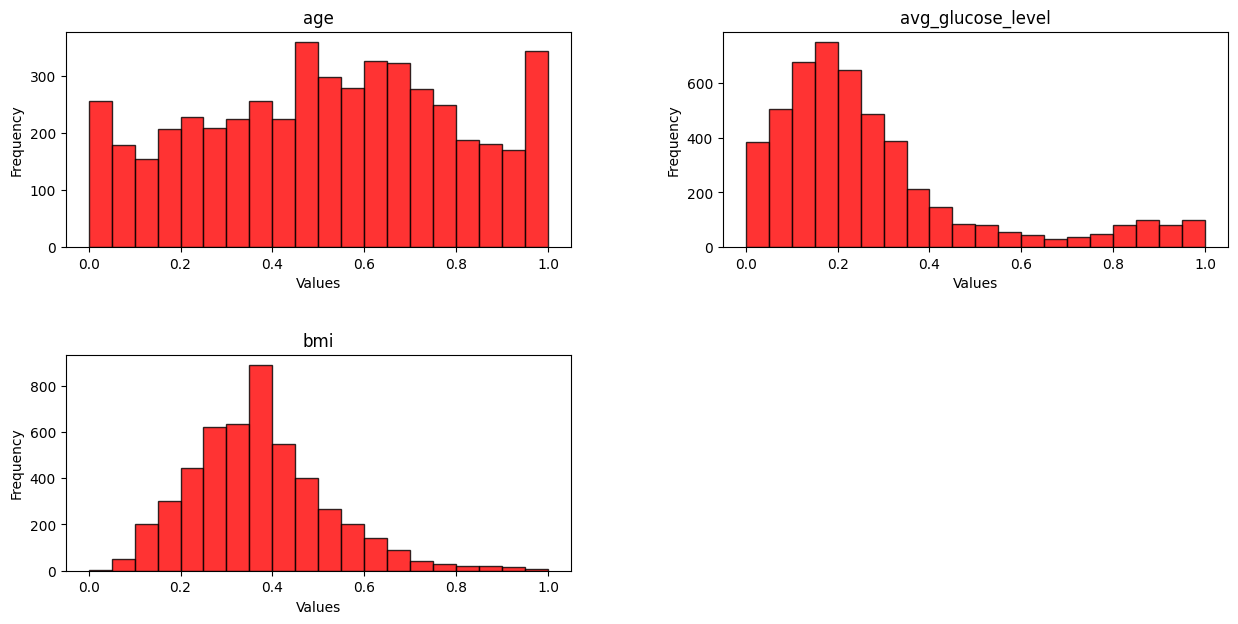


-------------------------------------------------
-------------------------------------------------
Median Imputed Data Numerical Values Visualization
-------------------------------------------------
-------------------------------------------------



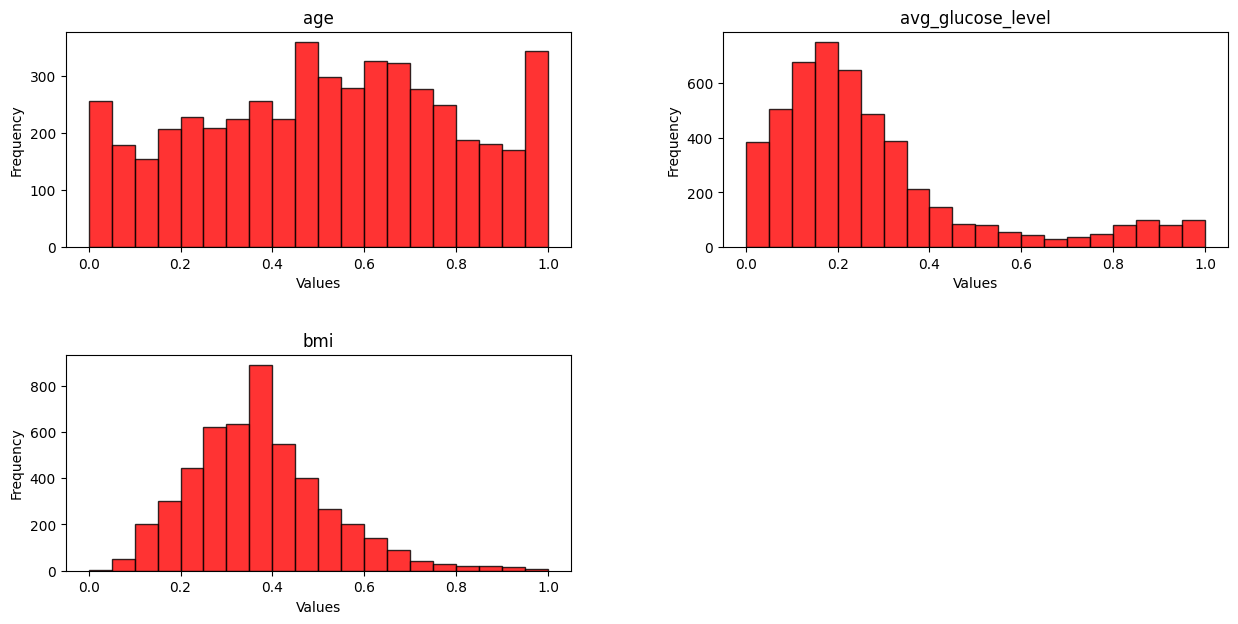

In [16]:
# your code here
numerical_features = df.select_dtypes(include=["float64"]).columns.tolist()
print("-------------------------------------------------")
print("-------------------------------------------------")
print("Mean Imputed Data Numerical Values Visualization")
print("-------------------------------------------------")
print("-------------------------------------------------\n")
visualize(df_mean_normalized, numerical_features, "hist", (15,7), 2, "stroke")
print("\n-------------------------------------------------")
print("-------------------------------------------------")
print("Median Imputed Data Numerical Values Visualization")
print("-------------------------------------------------")
print("-------------------------------------------------\n")
visualize(df_median_normalized, numerical_features, "hist", (15,7), 2, "stroke")

#### Secondary Visualizations for the Numerical Features:
Since there is a high similarity between the mean and median dataset, only the mean dataset will be checked for this section.

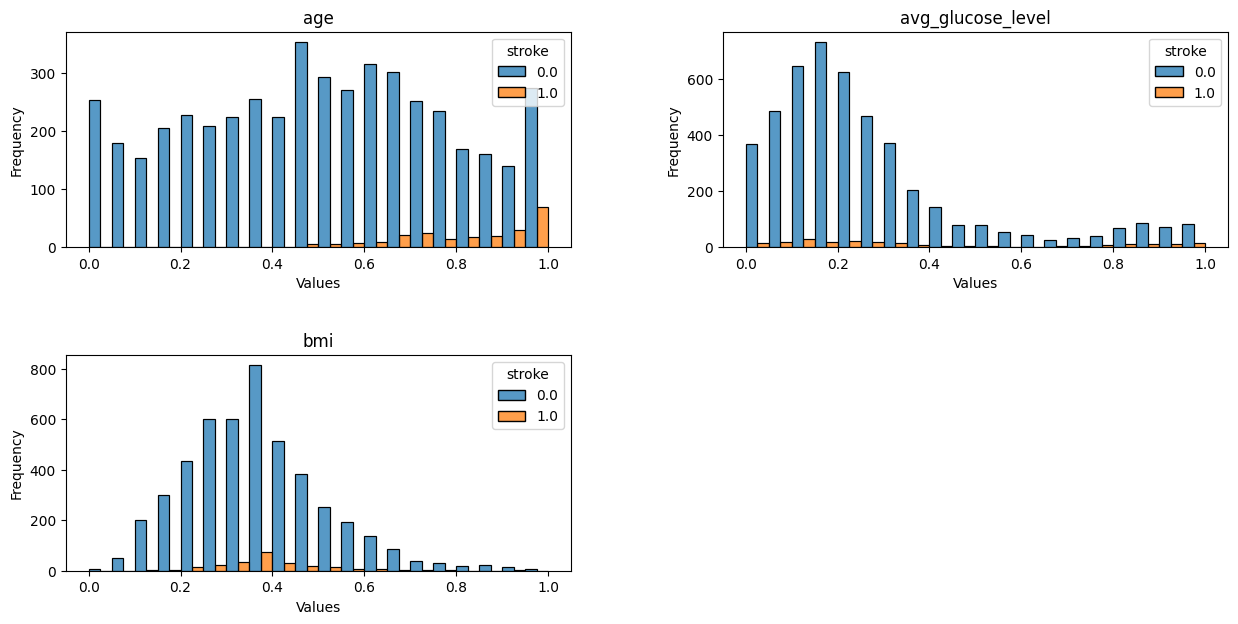

In [17]:
#Age vs stroke
visualize(df_mean_normalized, numerical_features, "histplot", (15,7), 2, "stroke")

### Relationship between categorical variable and the target variable
**Note: Since the categorical variables were encoded, it is logical to say that a "0" value in of the columns in a certain row means a "1" value in one of the rest columns in the same row. To fully understand the distribution of the encoded columns, only the frequency of the "1" values of each column will be visualized.**

#### Categorical Variable Distribution


-------------------------------------------------
-------------------------------------------------
Mean Normalized Categorical Data Visualization
-------------------------------------------------
-------------------------------------------------



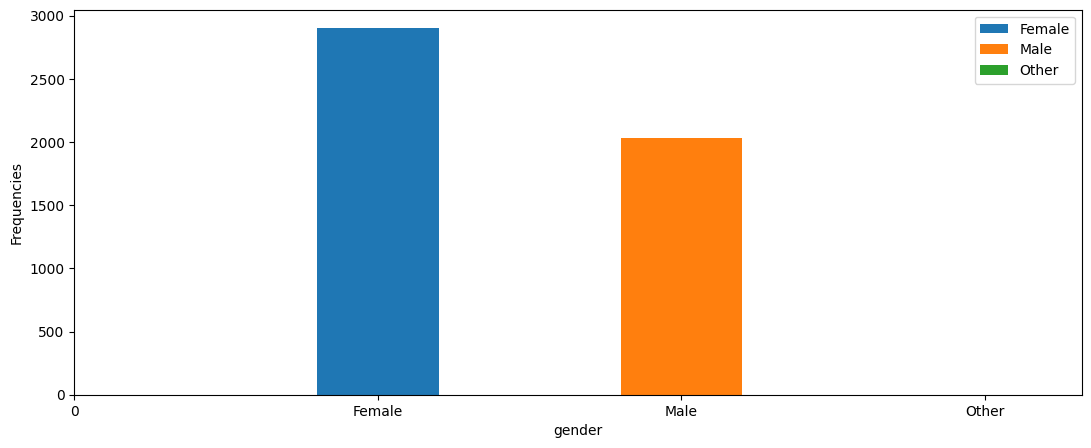

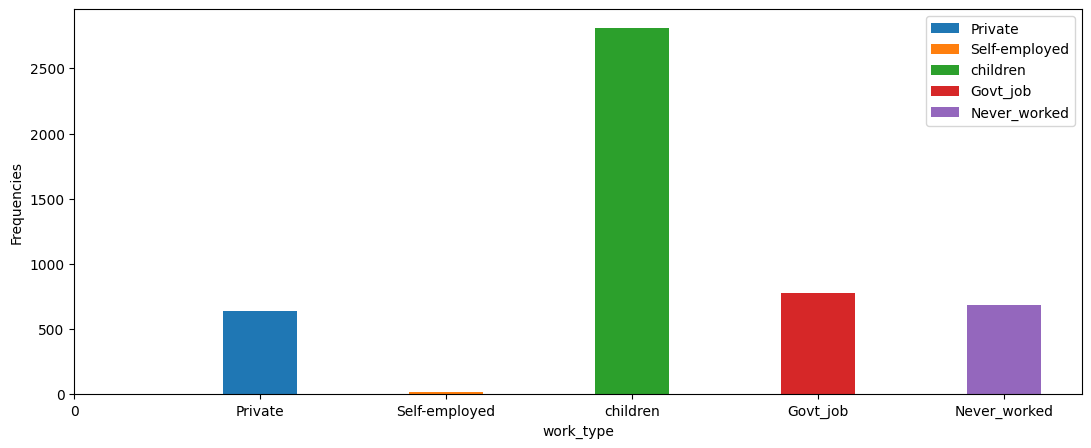


-------------------------------------------------
-------------------------------------------------
Median Normalized Categorical Data Visualization
-------------------------------------------------
-------------------------------------------------



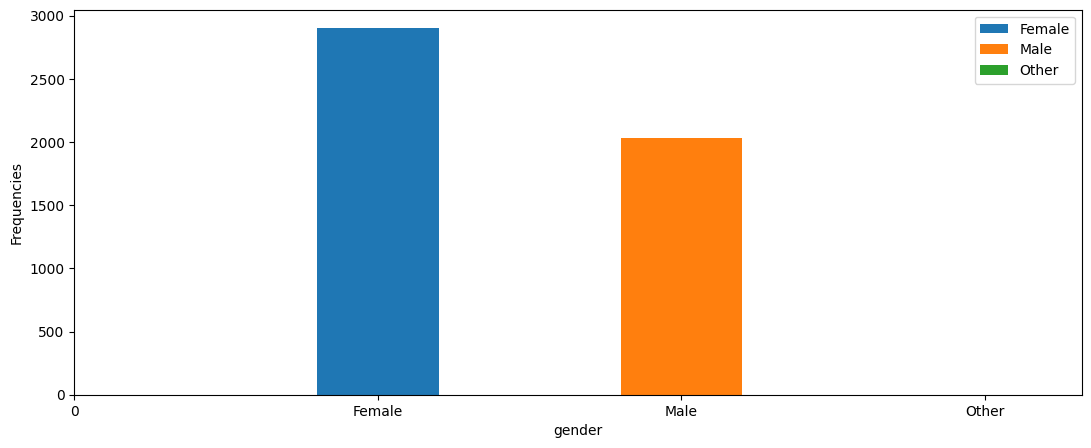

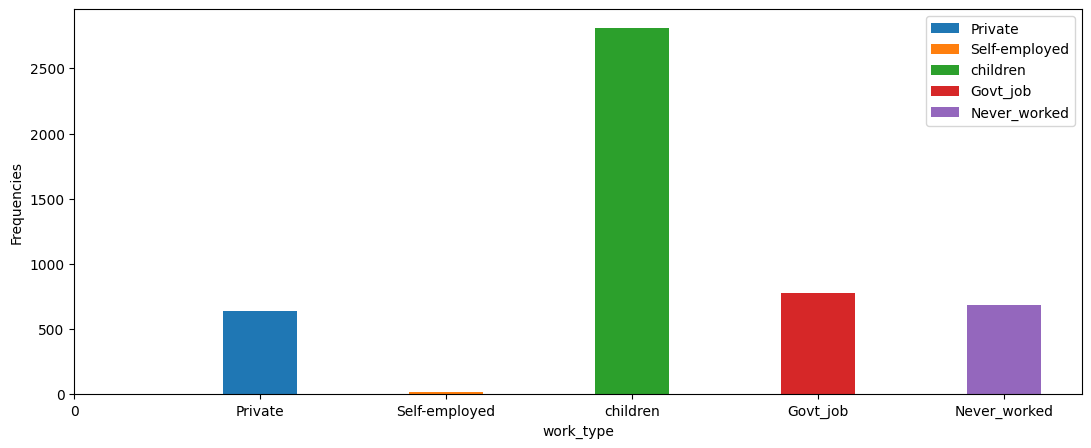

In [18]:
columns = ["gender","work_type"]
def multi_bars(dataframe):
    for subvalue in columns:
        plt.figure(figsize=(13,5))
        subvalue_encoded_columns = [value for value in dataframe.columns if subvalue in value] # the x values in the graph
        subvalue_normal_columns = df[subvalue].value_counts().index.tolist()
        for i in range(len(subvalue_encoded_columns)):
            column = subvalue_encoded_columns[i]
            column_counts = dataframe[dataframe[column] == 1][column].value_counts()
            plt.bar(column_counts.index + i, column_counts.values, width=0.4, label=subvalue_normal_columns[i])
        plt.xticks(ticks=range(len([0] + subvalue_encoded_columns)), labels=[0] + subvalue_normal_columns)
        plt.xlabel(subvalue)
        plt.ylabel("Frequencies")
        plt.legend()
        plt.show()
print("\n-------------------------------------------------")
print("-------------------------------------------------")
print("Mean Normalized Categorical Data Visualization")
print("-------------------------------------------------")
print("-------------------------------------------------\n")
multi_bars(df_mean_normalized)
print("\n-------------------------------------------------")
print("-------------------------------------------------")
print("Median Normalized Categorical Data Visualization")
print("-------------------------------------------------")
print("-------------------------------------------------\n")
multi_bars(df_median_normalized)

Mean


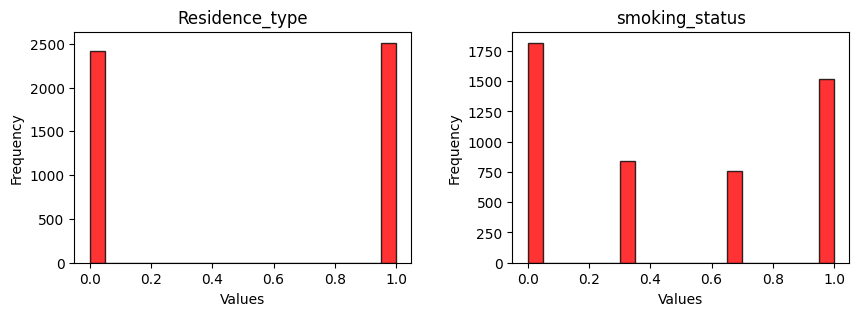

Median


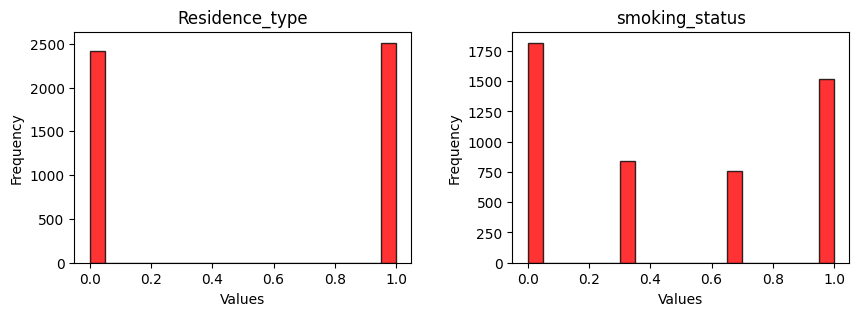

In [19]:
columns = ["Residence_type","smoking_status"]
print("Mean")
visualize(df_mean_normalized, columns, "hist", (10,3), 2, "stroke")
print("Median")
visualize(df_median_normalized, columns, "hist", (10,3), 2, "stroke")

#### Chi-Square Analysis:

In [20]:
columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
datasets = [df_mean_normalized, df_median_normalized]
def display_analysis(dataframe):
    for subvalue in columns:
        subvalue_encoded_columns = [value for value in df_mean_normalized.columns if subvalue in value] # the x values in the graph
        for column in subvalue_encoded_columns:
            chi2, p, dof, expected = chi_square(dataframe, [column,"stroke"])
            print("The chi score for **", column, "** is", chi2, "and the p value is", p)

print("-------------------------------------------------")
print("-------------------------------------------------")
print("Mean dataset")
print("-------------------------------------------------")
print("-------------------------------------------------\n")
display_analysis(df_mean_normalized)
print("\n-------------------------------------------------")
print("-------------------------------------------------")
print("Median dataset")
print("-------------------------------------------------")
print("-------------------------------------------------\n")
display_analysis(df_median_normalized)

-------------------------------------------------
-------------------------------------------------
Mean dataset
-------------------------------------------------
-------------------------------------------------

The chi score for ** gender_Female ** is 0.020955360904066113 and the p value is 0.884900628567389
The chi score for ** gender_Male ** is 0.022839507771772433 and the p value is 0.8798751749669538
The chi score for ** gender_Other ** is 0.0 and the p value is 1.0
The chi score for ** ever_married ** is 51.860570233207596 and the p value is 5.958503706577487e-13
The chi score for ** work_type_Govt_job ** is 0.2028647863143314 and the p value is 0.65241834248485
The chi score for ** work_type_Never_worked ** is 0.2733707443424905 and the p value is 0.601079558871917
The chi score for ** work_type_Private ** is 0.0225835045349913 and the p value is 0.8805452177965643
The chi score for ** work_type_Self-employed ** is 23.245361329402403 and the p value is 1.4259396167810289e-06
T

**<i>ever_married, work_type_Self_employed, work_type_children, smoking_status</i> have a high chi-score and a low p value. This suggests a strong relationship between the features and the target variable.
The rest of the features have a low chi-score and a high p value suggesting a weak relationship between them and the target value.
More to be verified in the correlation heatmap.**

#### Categorical vs Target Variables Visualzation:

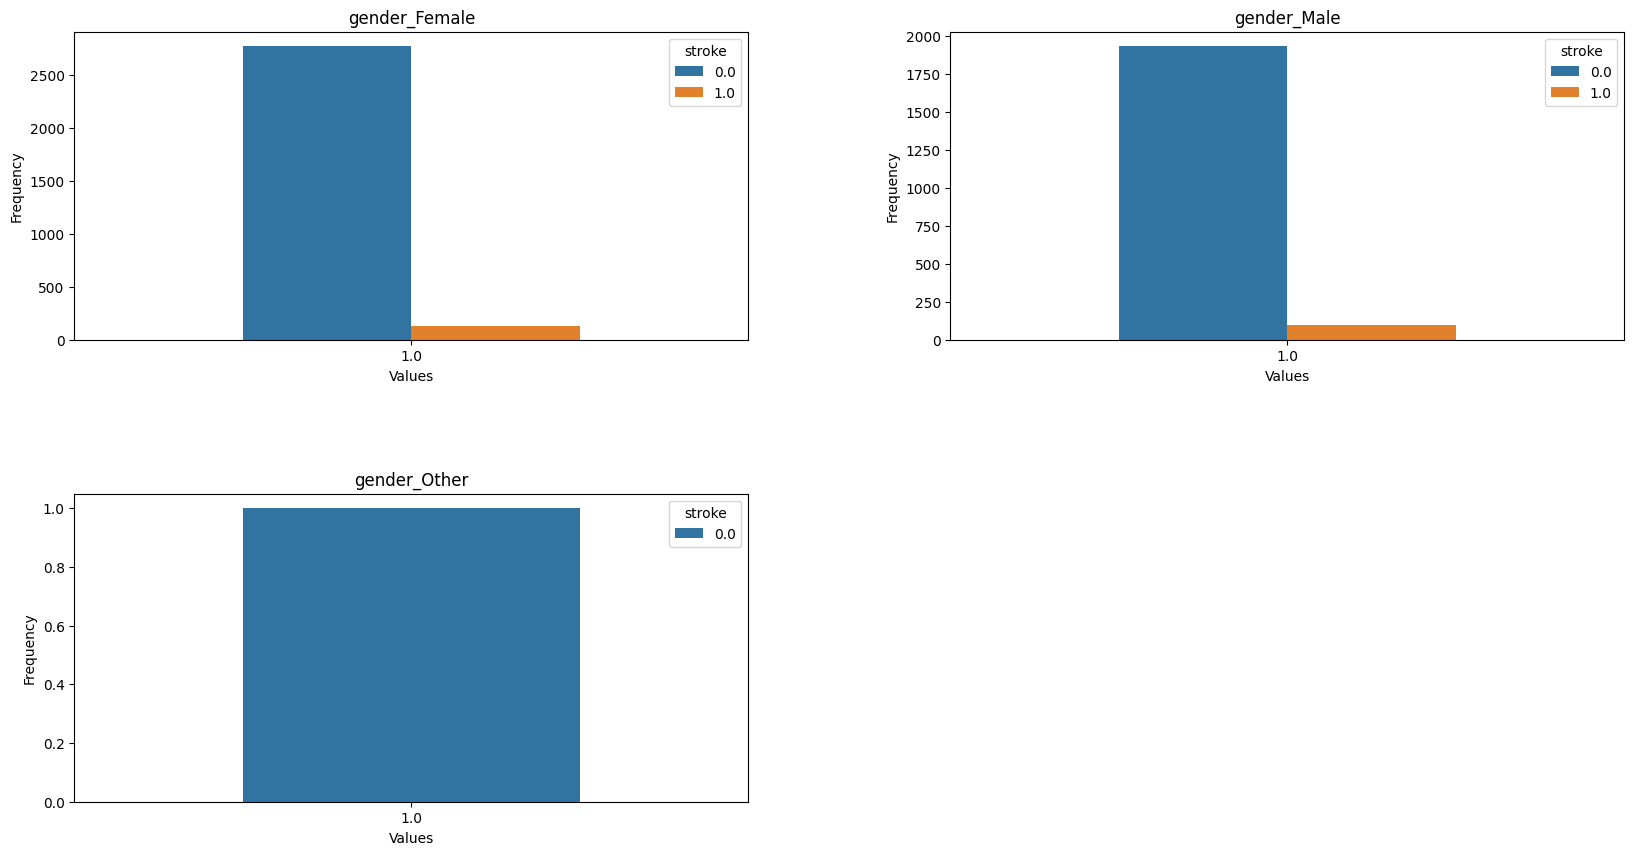

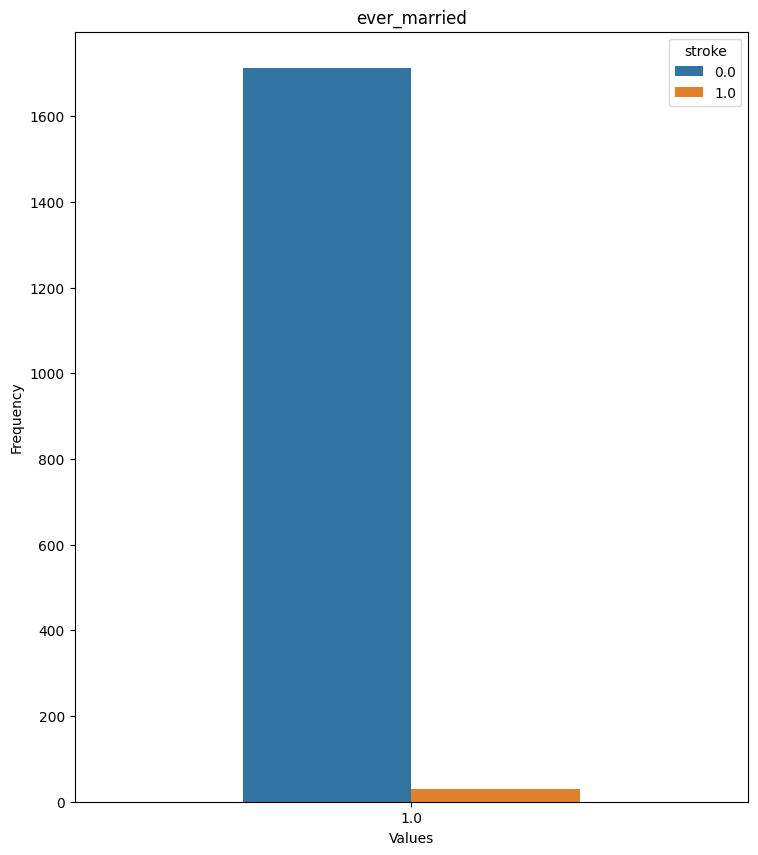

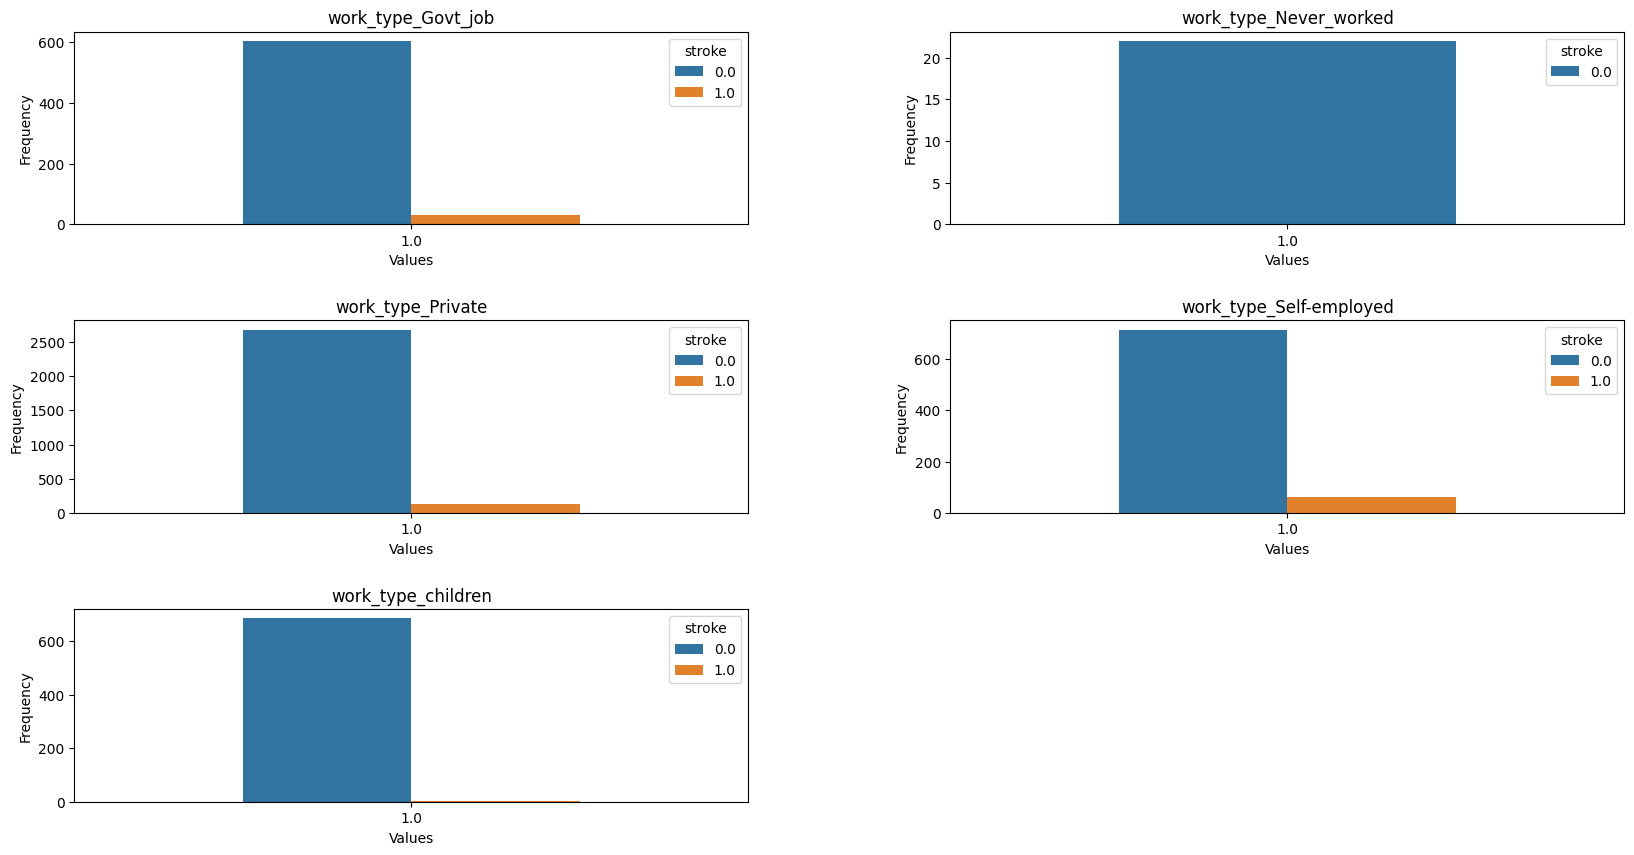

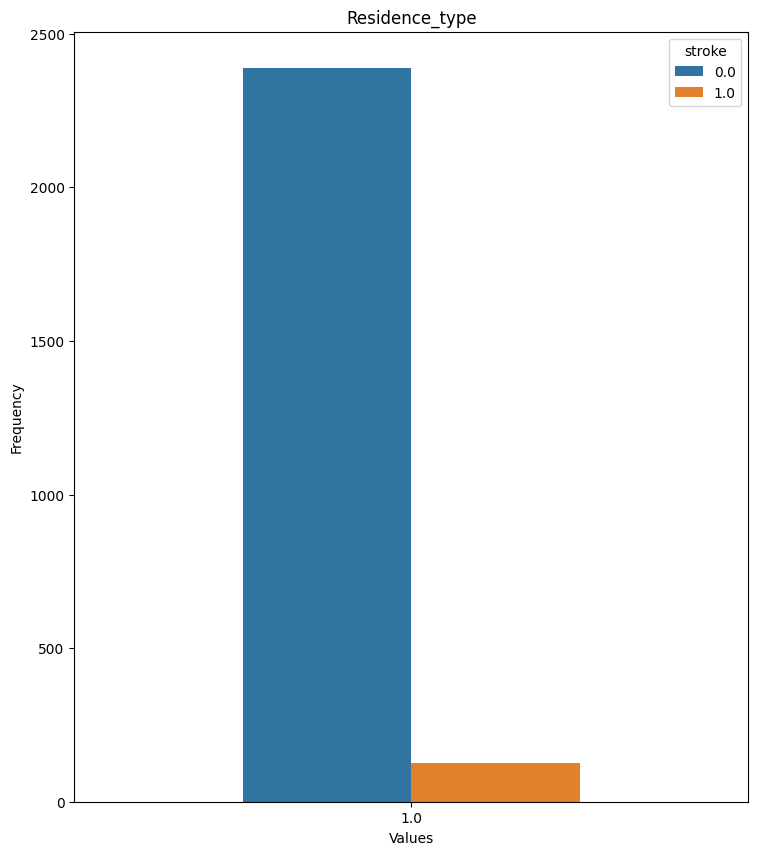

In [21]:
#SUPER IMPORTANT TO INDICATE THAT DATA IS UMBALANCED
normal_columns = ['gender', 'ever_married', 'work_type', 'Residence_type']
for subvalue in normal_columns:
    subvalue_encoded_columns = [value for value in df_mean_normalized.columns if subvalue in value] # the x values in the graph
    visualize(df_mean_normalized, subvalue_encoded_columns, "countplot", (20,10), 2, "stroke")
    print()

### Correlation Heatmap

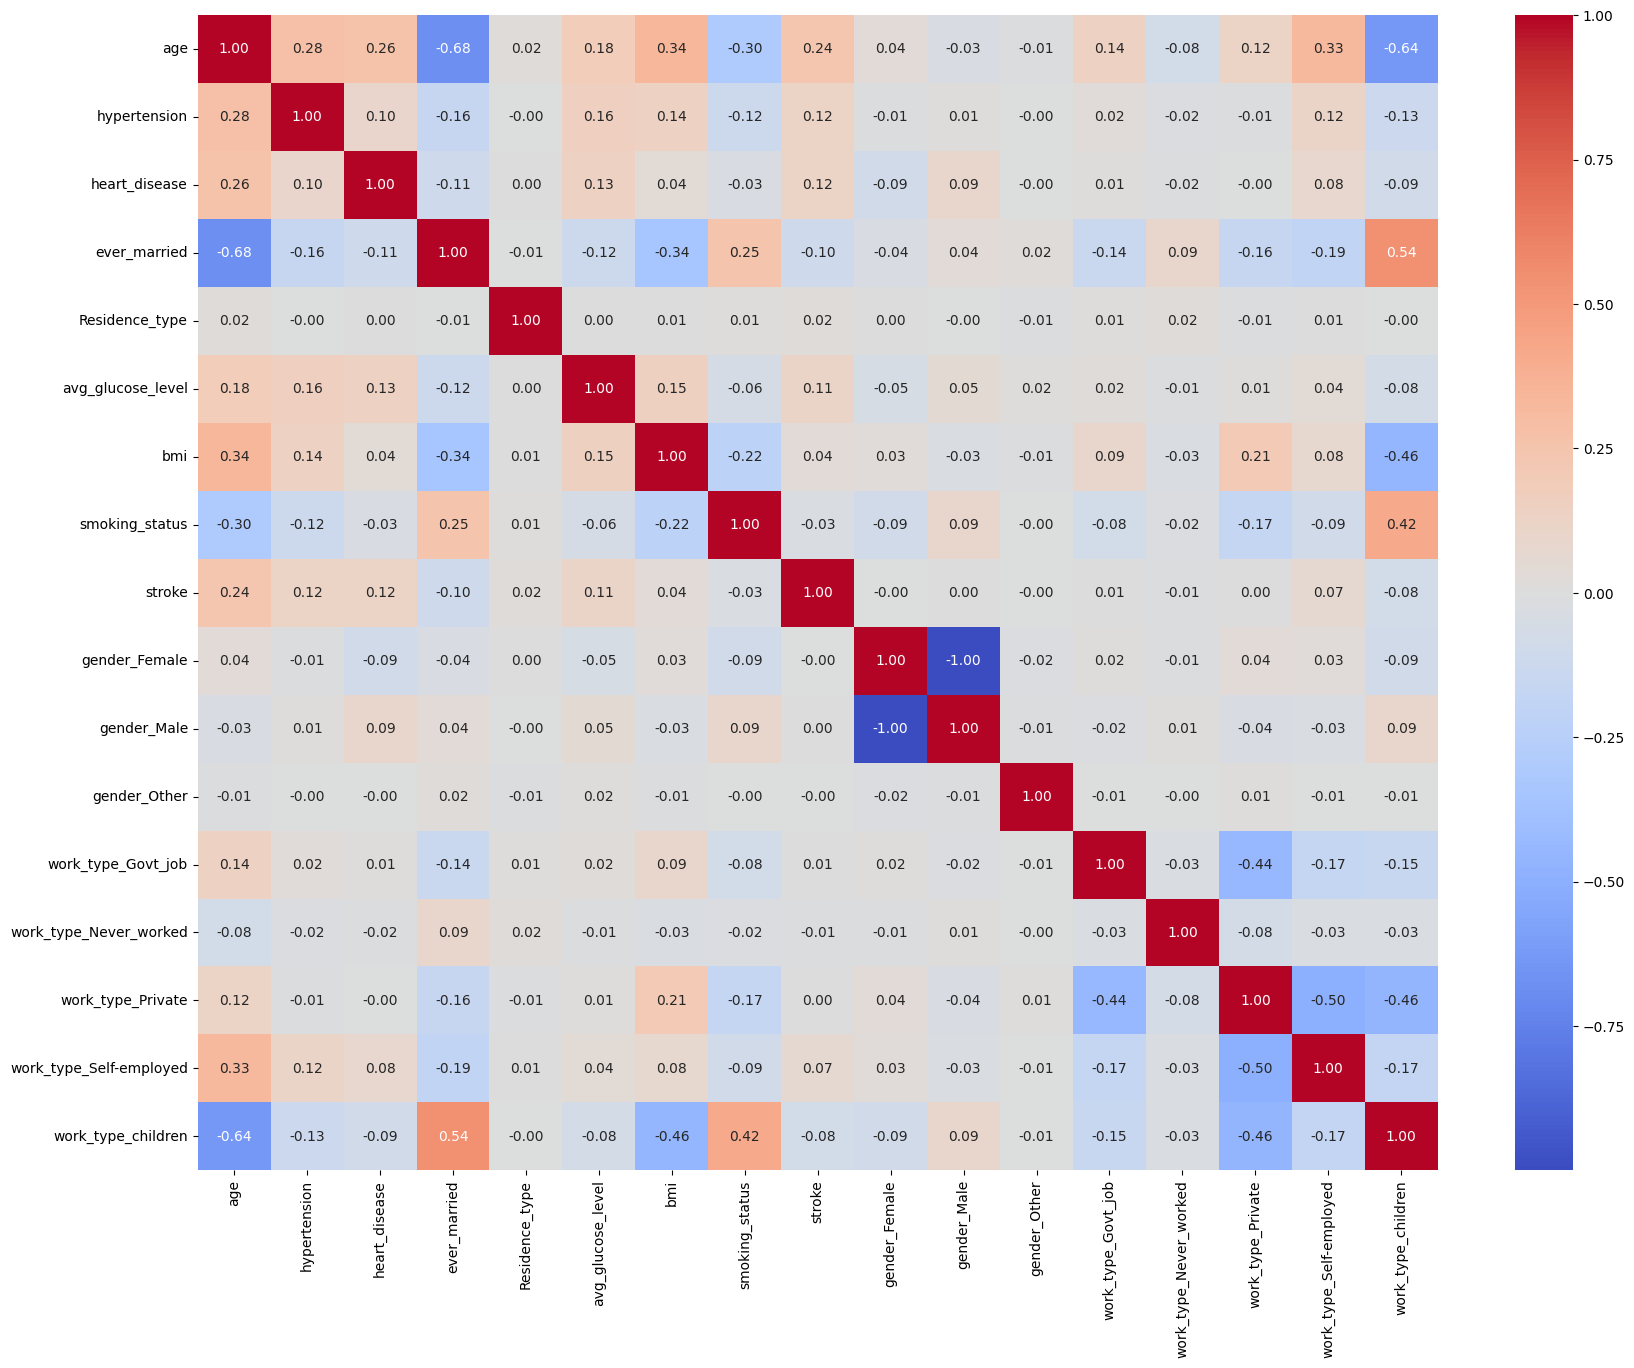

In [22]:
plt.figure(figsize=(20,15))
sn.heatmap(df_mean_normalized.corr(), cmap="coolwarm", annot=True, fmt='.2f')
plt.show()

In [23]:
normal_diabete_glucose_level = 100
prediabetes_glucose_level = 125
print(df[df["avg_glucose_level"] <= normal_diabete_glucose_level].shape[0], "patients with normal average glucose level.")
print(df[(df["avg_glucose_level"] > normal_diabete_glucose_level) & (df["avg_glucose_level"] <= prediabetes_glucose_level)].shape[0], "patients with prediabity average glucose level.")
print(df[df["avg_glucose_level"] > prediabetes_glucose_level].shape[0], "diabetic patients.")

3131 patients with normal average glucose level.
979 patients with prediabity average glucose level.
1000 diabetic patients.


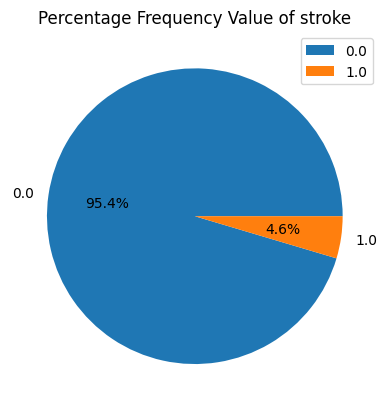

In [24]:
data = df_mean_normalized["stroke"].value_counts()
index = data.index
values = data.values
plt.pie(values, labels=index, autopct='%1.1f%%')
plt.title("Percentage Frequency Value of stroke")
plt.legend()
plt.show()

### Analysis Report:

- The visualizations, the chi-square, and the heatmap correlation indicate a very low difference between the mean imputation and median imputation method.
- For the distribution of the numerical features:
<ul>
    <li>Age is uniformly distributed with some peaks in the center and at the end. This indicates that the dataset spans evenly to different age groups. Using the <i>secondary visualizations for the numerical features,</i> the elderly are the ones that have a stroke. This is in accordance with heatmap correlation since the correlation between <i>age</i> and the <i>target value</i> is 0.24. When age increases, stroke increases (being 1).</li>
    <li>The <i>avg_glucose_level</i> is positively skewed with most values accumulated in the left. This means that most patients in the dataset have a low avg_glucose_value. So we can divide our dataset into two groups, one with low avg_glucose_value and one with a high avg_glucose_value. Medically speaking, we have three groups: A group with a normal average glucose level, a group with prediabity average glucose level, and a group of diabetic patients. The correlation is 0.11 between the <i>target variable</i> and <i>avg_glucose_level.</i> So the higher avg_glucose_level the more likely to have a stroke which is in accordance with the medical facts. According to the secondary visualizations, we notice that only groups with normal-to-average glucose level and high average glucose level are the ones having a stroke. This indicates that <b>other factors/features</b> are necessary for the classfication model.</li>
    <li><i>bmi</i> is slightly positively skewed. From the secondary visualizations for the numerical features, we notice that individuals with bmi centered around the mean have a stroke. The correlation heatmap suggests a very low positive correlation with the target variable.</li>
    <li><b>Important: The vast majority of the patients didn't have a stroke and a little of them had. This highly indicates an imblance of data for the classification models. Techniques such as oversampling, undersampling, or Synthetic Minority Oversampling Technique (SMOTE) can be applied to mitigate this problem.</b></li>
</ul>
Categorical Features:
<ul>
    <li>After categorical encoding and feature normalization, <i>ever_married, work_type_Self_employed, work_type_children, and smoking_status</i> have an important relationship with the target variable. </li>
    <li>The heatmap correlation indicate a high correlation with these features: <i>hypertension, hear_disease</i>. It also has some correlation with <i>work_type_Self_employed</i> and <i>work_type_children</i></li>
    <li>There is a low to no correlation in the <i>gender_Male, gender_Female, gender_Other, work_type_Govt_job, work_type_Never_worked, work_type_Private, and Residence_type</i>. These features can be removed the dataset for the classification models. As a result, two more datasets will be created, one with the low-correlated features removed and the normal ones.</li>
    <li>The categorical vs target variable visualizations show a big discreprency in the data with the group of patients not having stroke dominating the dataset.</li>
</ul>
- The pie chart confirms the data imbalance we have in the dataset.
- Because of the similairty of the mean and median imputed dataset and because of having some positively skewed features, Median Imputed dataset will be chosen dataset.

In [25]:
df_mean = df_mean_normalized.copy()
df_mean_features_removed = df_mean.drop(["gender_Female","gender_Male","gender_Other","work_type_Govt_job","work_type_Private","work_type_Never_worked","Residence_type"], axis=1)
df_median = df_median_normalized.copy()
df_median_features_removed = df_median.drop(["gender_Female","gender_Male","gender_Other","work_type_Govt_job","work_type_Private","work_type_Never_worked","Residence_type"], axis=1)

## 1.3. Data Splitting

* Dataset split into training (70%) and testing (30%) sets
* Dataset shuffled

**SMOTE will be used to handle data imbalance since it is much better to avoid overfitting.** -- EXPLAIN WHY

In [ ]:
#SMOTE
def split_data(dataframe: pd.DataFrame, target: str) -> tuple:
    X = dataframe.drop(target, axis=1)
    y = dataframe[target]
    return (X, y)

def combine(X: pd.DataFrame, y: pd.DataFrame) -> pd.DataFrame:
    df_combined = pd.concat([X, y], axis=1)
    return df_combined

def apply_smote(dataframe: pd.DataFrame) -> pd.DataFrame:
    X, y = split_data(dataframe, "stroke")
    X_smot, y_smot = smote.fit_resample(X, y)
    new_df = combine(X_smot, y_smot)
    return new_df

smote = SMOTE(random_state=42, sampling_strategy=0.7) #sampling_strategy 0.8 to reduce overfitting

In [27]:
#MEAN DATASET SMOTE
df_mean = apply_smote(df_mean)
#MEAN FEATURE REMOVED DATASET SMOTE
df_mean_features_removed = apply_smote(df_mean_features_removed)
#MEDIAN DATASET SMOTE
df_median = apply_smote(df_median)
#MEDIAN FEATURES REMOVED DATASET SMOTE
df_median_features_removed = apply_smote(df_median_features_removed)

In [28]:
#DATA SPLITTING
X_train_median, X_test_median, y_train_median, y_test_median = custom_train_test_split(df_median, 0.7, 0.3)
X_train_median_removed, X_test_median_removed, y_train_median_removed, y_test_median_removed = custom_train_test_split(df_median_features_removed, 0.7, 0.3)
X_train_mean, X_test_mean, y_train_mean, y_test_mean = custom_train_test_split(df_mean, 0.7, 0.3)
X_train_mean_removed, X_test_mean_removed, y_train_mean_removed, y_test_mean_removed = custom_train_test_split(df_mean_features_removed, 0.7, 0.3)

# **PART- 2: Model Building**

Implement two classification models:

* k-Nearest Neighbors (kNN)
* Logistic Regression



## 2.1. kNN Classifier


<b>To select the optimal k value, cross validation score can be used to evaluate the best k to have a more robust and reliable result rather than using the other error metrics.</b>

In [ ]:
# your code here
def optimal_k(X_train: pd.DataFrame, y_train: pd.DataFrame) -> dict:
    error_p = {}
    for p in range(1,3):
        accuracy = []
        for k in range(1, 22):
            knn_model = KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=p)
            score = cross_val_score(knn_model, X_train, y_train, cv=5).mean()
            accuracy.append(score)
        error_p[p] = accuracy
    return error_p

median = optimal_k(X_train_median, y_train_median)
median_removed = optimal_k(X_train_median_removed, y_train_median_removed)

mean = optimal_k(X_train_mean, y_train_mean)
mean_removed = optimal_k(X_train_mean_removed, y_train_mean_removed)

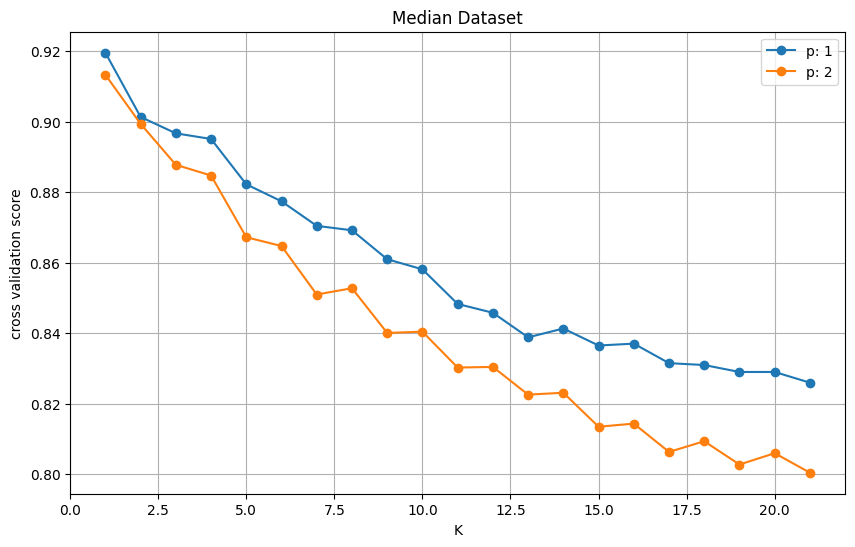

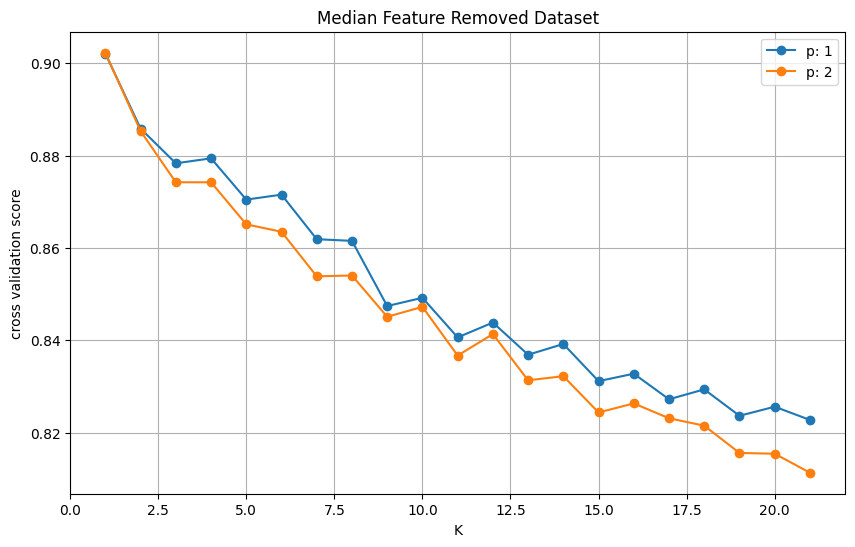

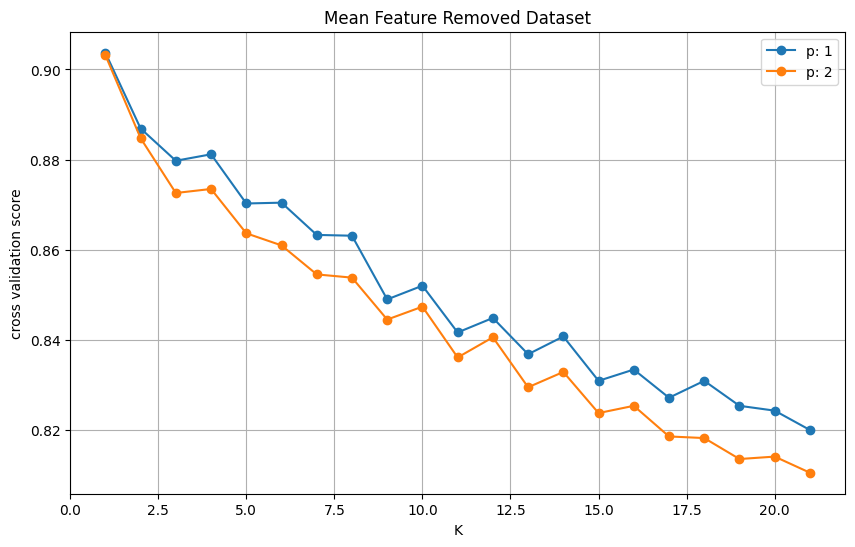

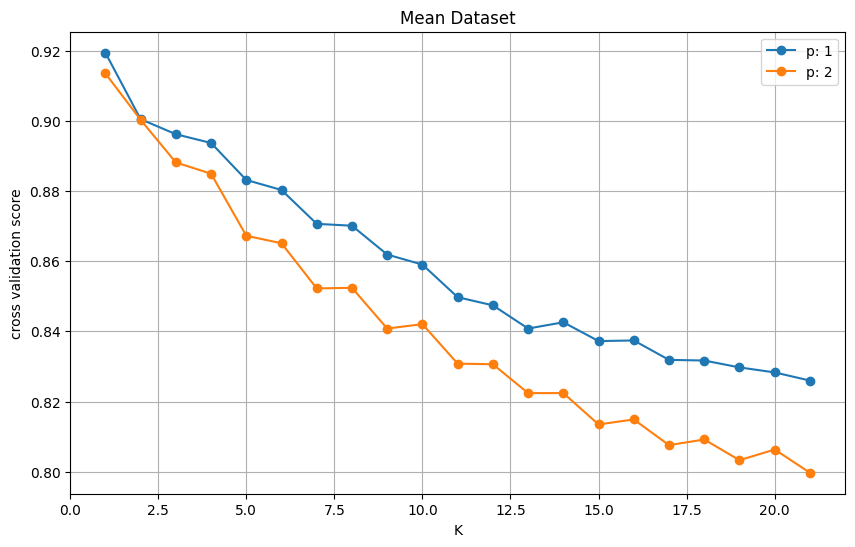

In [ ]:
def plot_optimal(error: dict, title: str) -> None:
    plt.figure(figsize=(10,6))
    for p, accuracy in error.items():
        plt.plot(range(1,22), accuracy, marker='o', label=f'p: {p}')
    plt.title(title)
    plt.xlabel("K")
    plt.ylabel("cross validation score")
    plt.legend()
    plt.grid()
    plt.show()

plot_optimal(median, "Median Dataset")
plot_optimal(median_removed, "Median Feature Removed Dataset")
plot_optimal(mean_removed, "Mean Feature Removed Dataset")
plot_optimal(mean, "Mean Dataset")

The cross validation score is at its highest when k = 1. Since the score is not a perfect score, k being 1 won't lead to a problem of overfitting. As a result:<br />
<b>The optimal k for all datasets will be 1</b><br />
<b>The optimal p for all datasets except <i>median_removed_features</i> dataset will be 1</b><br />
<b>The optimal p for the <i>median_removed_features</i> dataset will be 2</b>

### kNN Model Training

In [ ]:
def kNN_model(X_train: pd.DataFrame, y_train: pd.DataFrame, k: int, p: int) -> KNeighborsClassifier:
    kNN = KNeighborsClassifier(n_neighbors=k, metric="minkowski", p = p)
    kNN.fit(X_train, y_train)
    return kNN

kNN_median = kNN_model(X_train_median, y_train_median, 1, 1)
kNN_median_removed = kNN_model(X_train_median_removed, y_train_median_removed, 1, 2)
kNN_mean = kNN_model(X_train_mean, y_train_mean, 1, 1)
kNN_mean_removed = kNN_model(X_train_mean_removed, y_train_mean_removed, 1, 1)

## 2.2. Logistic Regression

In [ ]:
# your code here
def logistic_model(X_train: pd.DataFrame, y_train: pd.DataFrame) -> LogisticRegression:
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)
    return logistic_regression

logistic_median = logistic_model(X_train_median, y_train_median)
logsitic_median_removed = logistic_model(X_train_median_removed, y_train_median_removed)
logsitic_mean = logistic_model(X_train_mean, y_train_mean)
logsitic_mean_removed = logistic_model(X_train_mean_removed, y_train_mean_removed)


# **PART- 3: Model Evaluation**



## 3.1 Confusion Matrix

Analysis of the confusion matrices for both models:

* The confusion matrices plotted and interpreted
* Accuracy, precision, recall, and F1-score calculated for both models



#### kNN Model

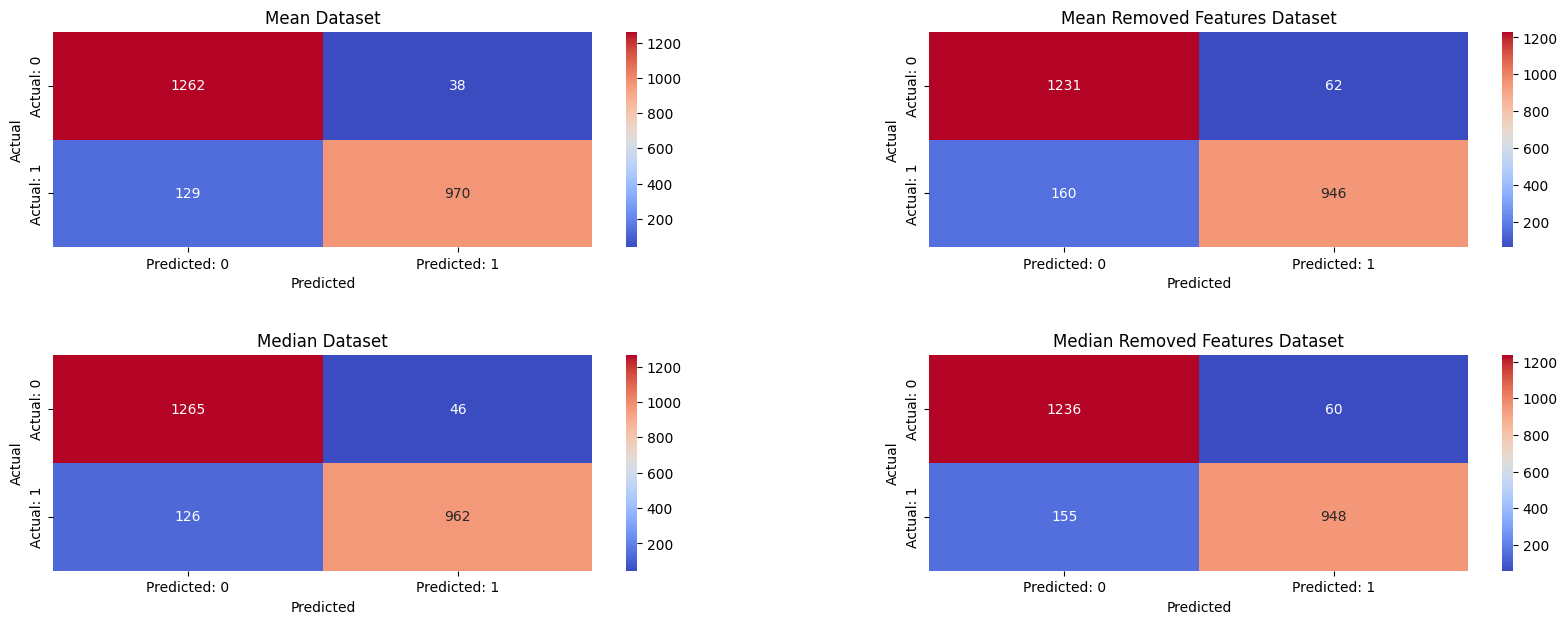

In [ ]:
# your code here
y_pred_median = kNN_median.predict(X_test_median)
y_pred_median_removed = kNN_median_removed.predict(X_test_median_removed)
y_pred_mean = kNN_mean.predict(X_test_mean)
y_pred_mean_removed = kNN_mean_removed.predict(X_test_mean_removed)

cm_median = confusion_matrix(y_pred_median, y_test_median)
cm_median_removed = confusion_matrix(y_pred_median_removed, y_test_median_removed)
cm_mean = confusion_matrix(y_pred_mean, y_test_mean)
cm_mean_removed = confusion_matrix(y_pred_mean_removed, y_test_mean_removed)

def plot_confusion(cms: dict) -> None:
    _, axes = plt.subplots(2,2, figsize=(20,7))
    axes = axes.flatten()
    for index, name in enumerate(cms):
        ax = axes[index]
        sn.heatmap(cms[name], annot=True, fmt='d', cmap="coolwarm", xticklabels=["Predicted: 0", "Predicted: 1"], yticklabels=["Actual: 0", "Actual: 1"], ax=ax)
        ax.set_title(name)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()


cms_kNN = {
    "Mean Dataset": cm_mean,
    "Mean Removed Features Dataset":cm_mean_removed,
    "Median Dataset":cm_median,
    "Median Removed Features Dataset":cm_median_removed
}
plot_confusion(cms_kNN)

#### kNN Confusion Matrix Report:
- For the <b>mean dataset</b>:
<ul>
    <li>There are 1262 true positives and 970 true negatives. Because the of the data imbalance and the parameters we used to handle them, it is consistent to have more true positives than true negatives.</li>
    <li>There are 129 false negatives 38 false positives. This can be beneficial in a way that identifiying wrong patients results in uncessary stress and unecessary expenses from both the health institutions and the patients themselves.</li>
    <li><b>The mean model indicates an overall good performance which will be later verified by the accuracy, precision, and recall metrices.</b></li>
</ul>
- For the <b>mean dataset with some of the low correlated features removed</b>:
<ul>
    <li>The confusion matrices indicate a decrease in the true positives, from 1262 to 1231, and a decrease in the true negatives from 970 to 946. There is a however an increase in the false negatives and positives. This explains that the model with the features removed didn't perform better, quite the oposite. </li>
</ul>
- For the <b>Median Dataset:</b>
<ul>
    <li>The median dataset has very similar scores as the mean dataset.The true positives are 1265 and true negatives are 962. It is slightly worse than the mean dataset. There is a slight decrease in the false negatives from 129 to 126 and a slight increase in the false positives from 38 to 46.</li>
</ul>
- For the <b>Median dataset with some of the low correlated features removed:</b>
<ul>
    <li>The overall performance is slightly worse than the median dataset indicating the importance of the features removed.</li>
</ul>

In [ ]:
def metrics(cm: dict, n: int, name: str) -> tuple:
    TP = cm[0][0]
    TN = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    accuracy = (TP + TN) / n
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_1 = 2 / ((1 / precision) + (1 / recall))
    print("The accuracy of the", name, "is", accuracy)
    print("The precision of the", name, "is", precision)
    print("The recall of the", name, "is", recall)
    print("The F-1 score of the", name, "is", f_1)
    return (accuracy, precision, recall, f_1)
print("Median Dataset:")
kNN_accuracy_median, kNN_precision_median, kNN_recall_median, kNN_f_1_median = metrics(cm_median, y_test_median.shape[0], "kNN median dataset model")
print("------------------------------------------------------------------")
print("------------------------------------------------------------------")
print("Median Features Removed Dataset:")
kNN_accuracy_removed_median, kNN_precision_removed_median, kNN_recall_removed_median, kNN_f_1_removed_median = metrics(cm_median_removed, y_test_median_removed.shape[0], "kkNN median features removed dataset model")
print("------------------------------------------------------------------")
print("------------------------------------------------------------------")
print("Mean Dataset:")
kNN_accuracy_mean, kNN_precision_mean, kNN_recall_mean, kNN_f_1_mean = metrics(cm_mean, y_test_mean.shape[0], "kkNN mean dataset model")
print("------------------------------------------------------------------")
print("------------------------------------------------------------------")
print("Mean Features Removed Dataset:")
kNN_accuracy_removed_mean, kNN_precision_removed_mean, kNN_recall_removed_mean, kNN_f_1_removed_mean = metrics(cm_mean_removed, y_test_mean_removed.shape[0], "kkNN mean features removed dataset model")

Median Dataset:
The accuracy of the kNN median dataset model is 0.9283034597749062
The precision of the kNN median dataset model is 0.9649122807017544
The recall of the kNN median dataset model is 0.9094176851186196
The F-1 score of the kNN median dataset model is 0.9363434492968171
------------------------------------------------------------------
------------------------------------------------------------------
Median Features Removed Dataset:
The accuracy of the kkNN median features removed dataset model is 0.9103793247186328
The precision of the kkNN median features removed dataset model is 0.9537037037037037
The recall of the kkNN median features removed dataset model is 0.888569374550683
The F-1 score of the kkNN median features removed dataset model is 0.9199851135094902
------------------------------------------------------------------
------------------------------------------------------------------
Mean Dataset:
The accuracy of the kkNN mean dataset model is 0.9303876615256

#### Logistic Regression

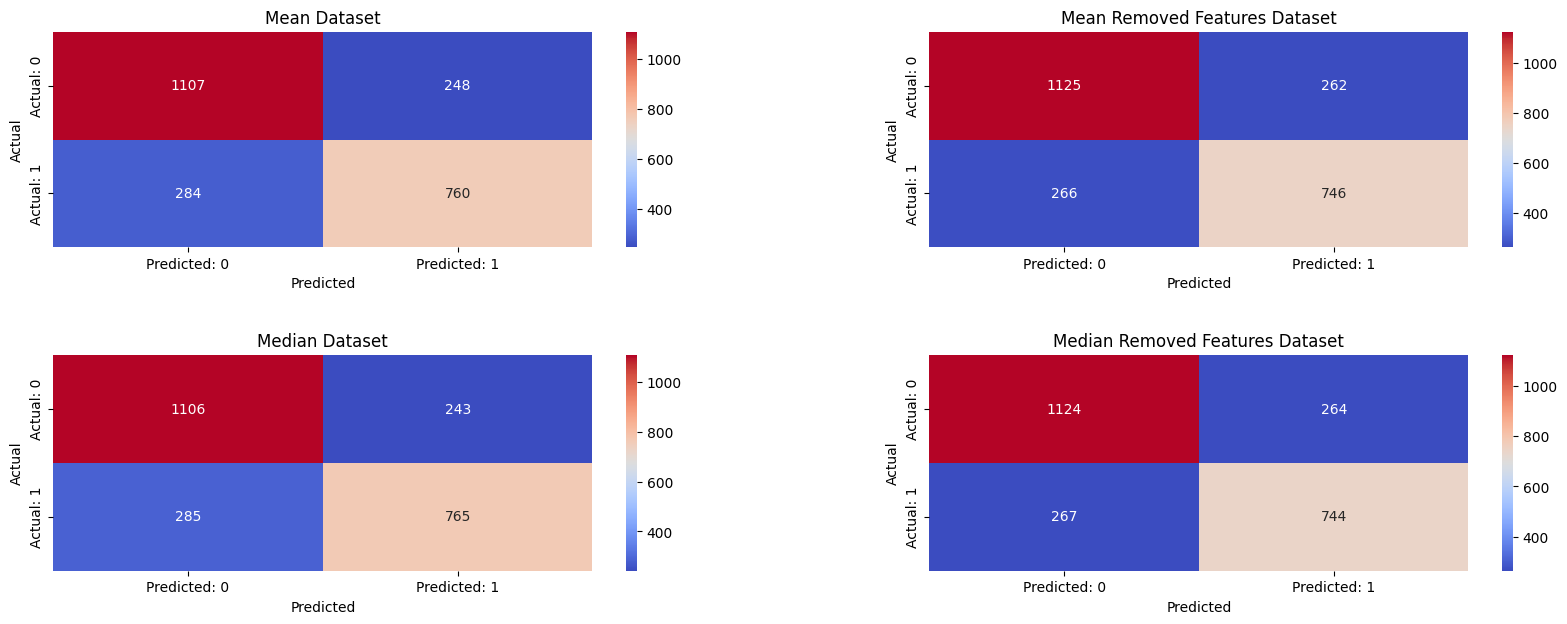

In [35]:
logistic_y_pred_median = logistic_median.predict(X_test_median)
logistic_y_pred_median_removed = logsitic_median_removed.predict(X_test_median_removed)
logistic_y_pred_mean = logsitic_mean.predict(X_test_mean)
logistic_y_pred_mean_removed = logsitic_mean_removed.predict(X_test_mean_removed)

logistic_cm_median = confusion_matrix(logistic_y_pred_median, y_test_median)
logistic_cm_median_removed = confusion_matrix(logistic_y_pred_median_removed, y_test_median_removed)
logistic_cm_mean = confusion_matrix(logistic_y_pred_mean, y_test_mean)
logistic_cm_mean_removed = confusion_matrix(logistic_y_pred_mean_removed, y_test_mean_removed)

cms_logistic = {
    "Mean Dataset": logistic_cm_mean,
    "Mean Removed Features Dataset": logistic_cm_mean_removed,
    "Median Dataset": logistic_cm_median,
    "Median Removed Features Dataset": logistic_cm_median_removed,
}
plot_confusion(cms_logistic)

#### Logistic Regression Confusion Matrix Report:
- For the <b>mean dataset</b>:
<ul>
    <li>There are 1107 true positives and 760 true negatives. Same thing for this model, due to the data imbalance, it is expected to have more true positives than true negatives.</li>
    <li>There are 284 false negatives 248 than false positives.</li>
    <li><b>The mean model indicates an overall good performance which will be later verified by the accuracy, precision, and recall metrices.</b></li>
</ul>
- For the <b>mean dataset with some of the low correlated features removed</b>:
<ul>
    <li>The confusion matrices indicate an increase in the true positives, from 1107 to 1125, and a decrease in the true negatives from 760 to 746. There is however a decrease in the false negatives and an increase in the false positives. This indicates that the logistic regression model is suceptible to the curse of dimensionality.</li>
</ul>
- For the <b>Median Dataset:</b>
<ul>
    <li>The median dataset has very similar scores as the mean dataset.The true positives are 1106 and true negatives are 765 It is slightly better than the mean dataset. The false negatives and false positives are also very similar with the median and mean datasets.</li>
</ul>
- For the <b>Median dataset with some of the low correlated features removed:</b>
<ul>
    <li>The overall performance is slightly better than the median dataset veryifying that logistic regression performs well in low dimensional datasets.</li>
</ul>
- We notice that logistic regression was good enough to classify the positives into true positives but a little bit worse with the classifying the negatives, this can be deduced from the data imbalance of this dataset.

In [36]:
print("Median Dataset:")
logistic_accuracy_median, logistic_precision_median, logistic_recall_median, logistic_f_1_median = metrics(logistic_cm_median, y_test_median.shape[0], "Logistic median dataset model")
print("------------------------------------------------------------------")
print("------------------------------------------------------------------")
print("Median Features Removed Dataset:")
logistic_accuracy_median_removed, logistic_precision_median_removed, logistic_recall_median_removed, logistic_f_1_median_removed = metrics(logistic_cm_median_removed, y_test_median_removed.shape[0], "Logistic median features removed dataset model")
print("------------------------------------------------------------------")
print("------------------------------------------------------------------")
print("Mean Dataset:")
logistic_accuracy_mean, logitstic_precision_mean, logistic_recall_mean, logistic_f_1_mean = metrics(logistic_cm_mean, y_test_mean.shape[0], "Logistic mean dataset model")
print("------------------------------------------------------------------")
print("------------------------------------------------------------------")
print("Mean Features Removed Dataset:")
logistic_accuracy_mean_removed, logistic_precision_mean_removed, logistic_recall_mean_removed, logistic_f_1_mean_removed = metrics(logistic_cm_mean_removed, y_test_mean_removed.shape[0], "Logistic mean features removed dataset model")
print("------------------------------------------------------------------")
print("------------------------------------------------------------------")

Median Dataset:
The accuracy of the Logistic median dataset model is 0.7799082951229679
The precision of the Logistic median dataset model is 0.8198665678280208
The recall of the Logistic median dataset model is 0.7951114306254493
The F-1 score of the Logistic median dataset model is 0.8072992700729926
------------------------------------------------------------------
------------------------------------------------------------------
Median Features Removed Dataset:
The accuracy of the Logistic median features removed dataset model is 0.7786577740725302
The precision of the Logistic median features removed dataset model is 0.8097982708933718
The recall of the Logistic median features removed dataset model is 0.8080517613227893
The F-1 score of the Logistic median features removed dataset model is 0.8089240734077006
------------------------------------------------------------------
------------------------------------------------------------------
Mean Dataset:
The accuracy of the Logis

For both models:
- The scores of the median and mean dataset are very close to each other.
- The scores of the datasets with the features removed have a lower score than the other datasets. While it can indicate a lower performance, it is not a very serious decrease because it can also be used against overfitting.

## 3.2 Precision-Recall Curves

Evaluation of Precision-Recall curves for both models:

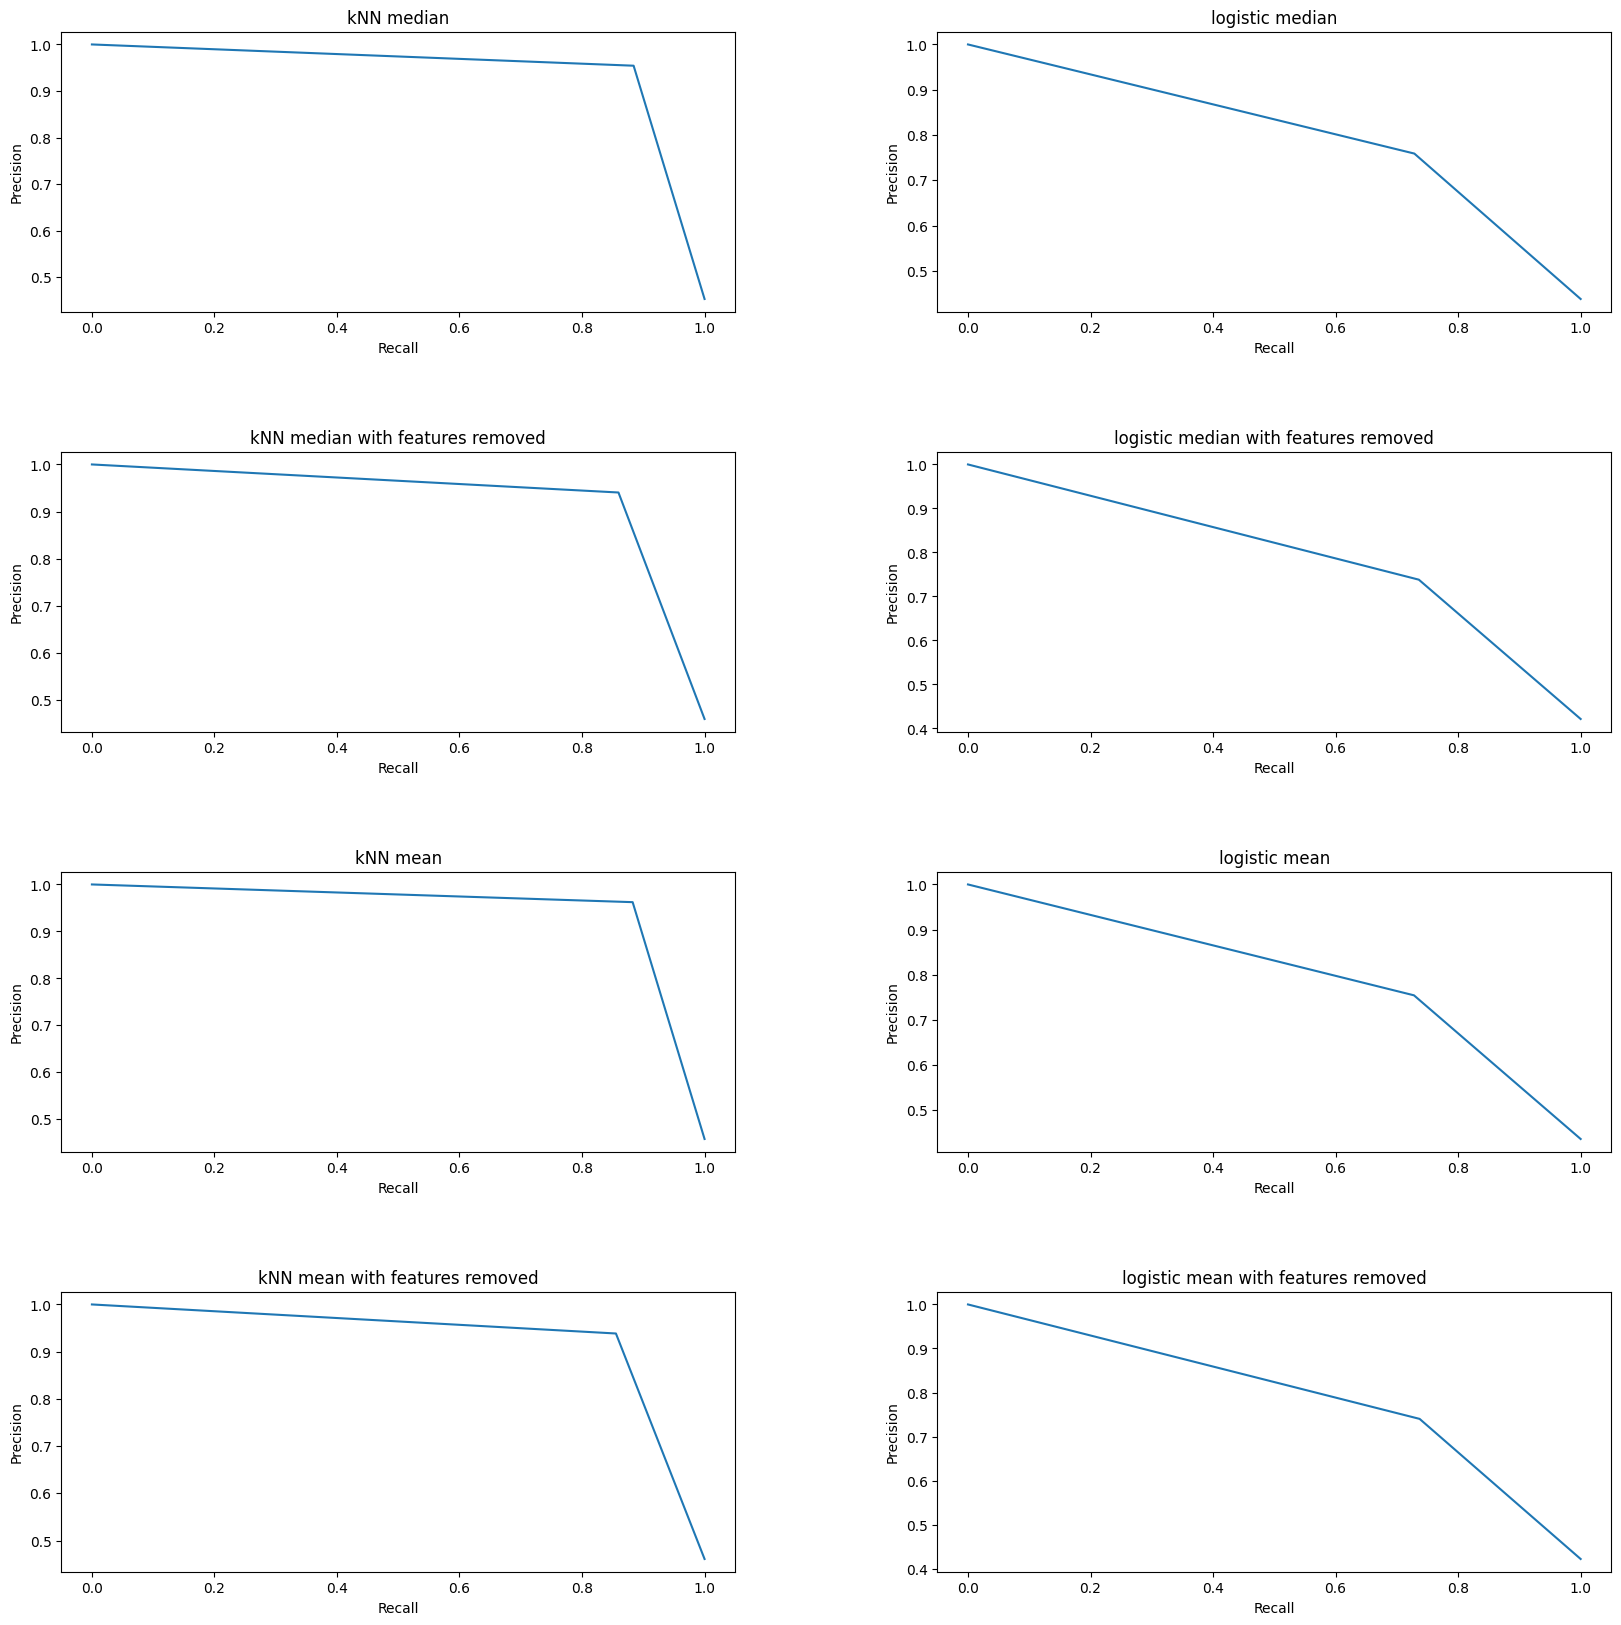

In [37]:
# your code here
data = {
    "kNN median": [y_pred_median, y_test_median],
    "logistic median": [logistic_y_pred_median, y_test_median],
    "kNN median with features removed": [y_pred_median_removed, y_test_median_removed],
    "logistic median with features removed": [logistic_y_pred_median_removed, y_test_median_removed],
    "kNN mean": [y_pred_mean, y_test_mean],
    "logistic mean": [logistic_y_pred_mean, y_test_mean],
    "kNN mean with features removed": [y_pred_mean_removed, y_test_mean_removed],
    "logistic mean with features removed": [logistic_y_pred_mean_removed, y_test_mean_removed]
}
fig, axes = plt.subplots(4,2, figsize=(20,20))
axes = axes.flatten()
for index, name in enumerate(data):
    ax = axes[index]
    precision, recall, thresholds = precision_recall_curve(data[name][0], data[name][1])
    ax.plot(recall, precision)
    ax.set_title(name)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

## 3.3. Compare the Model

A detailed evaluation report with metrics, visualizations, and comparative analysis.

#### ROC Curve

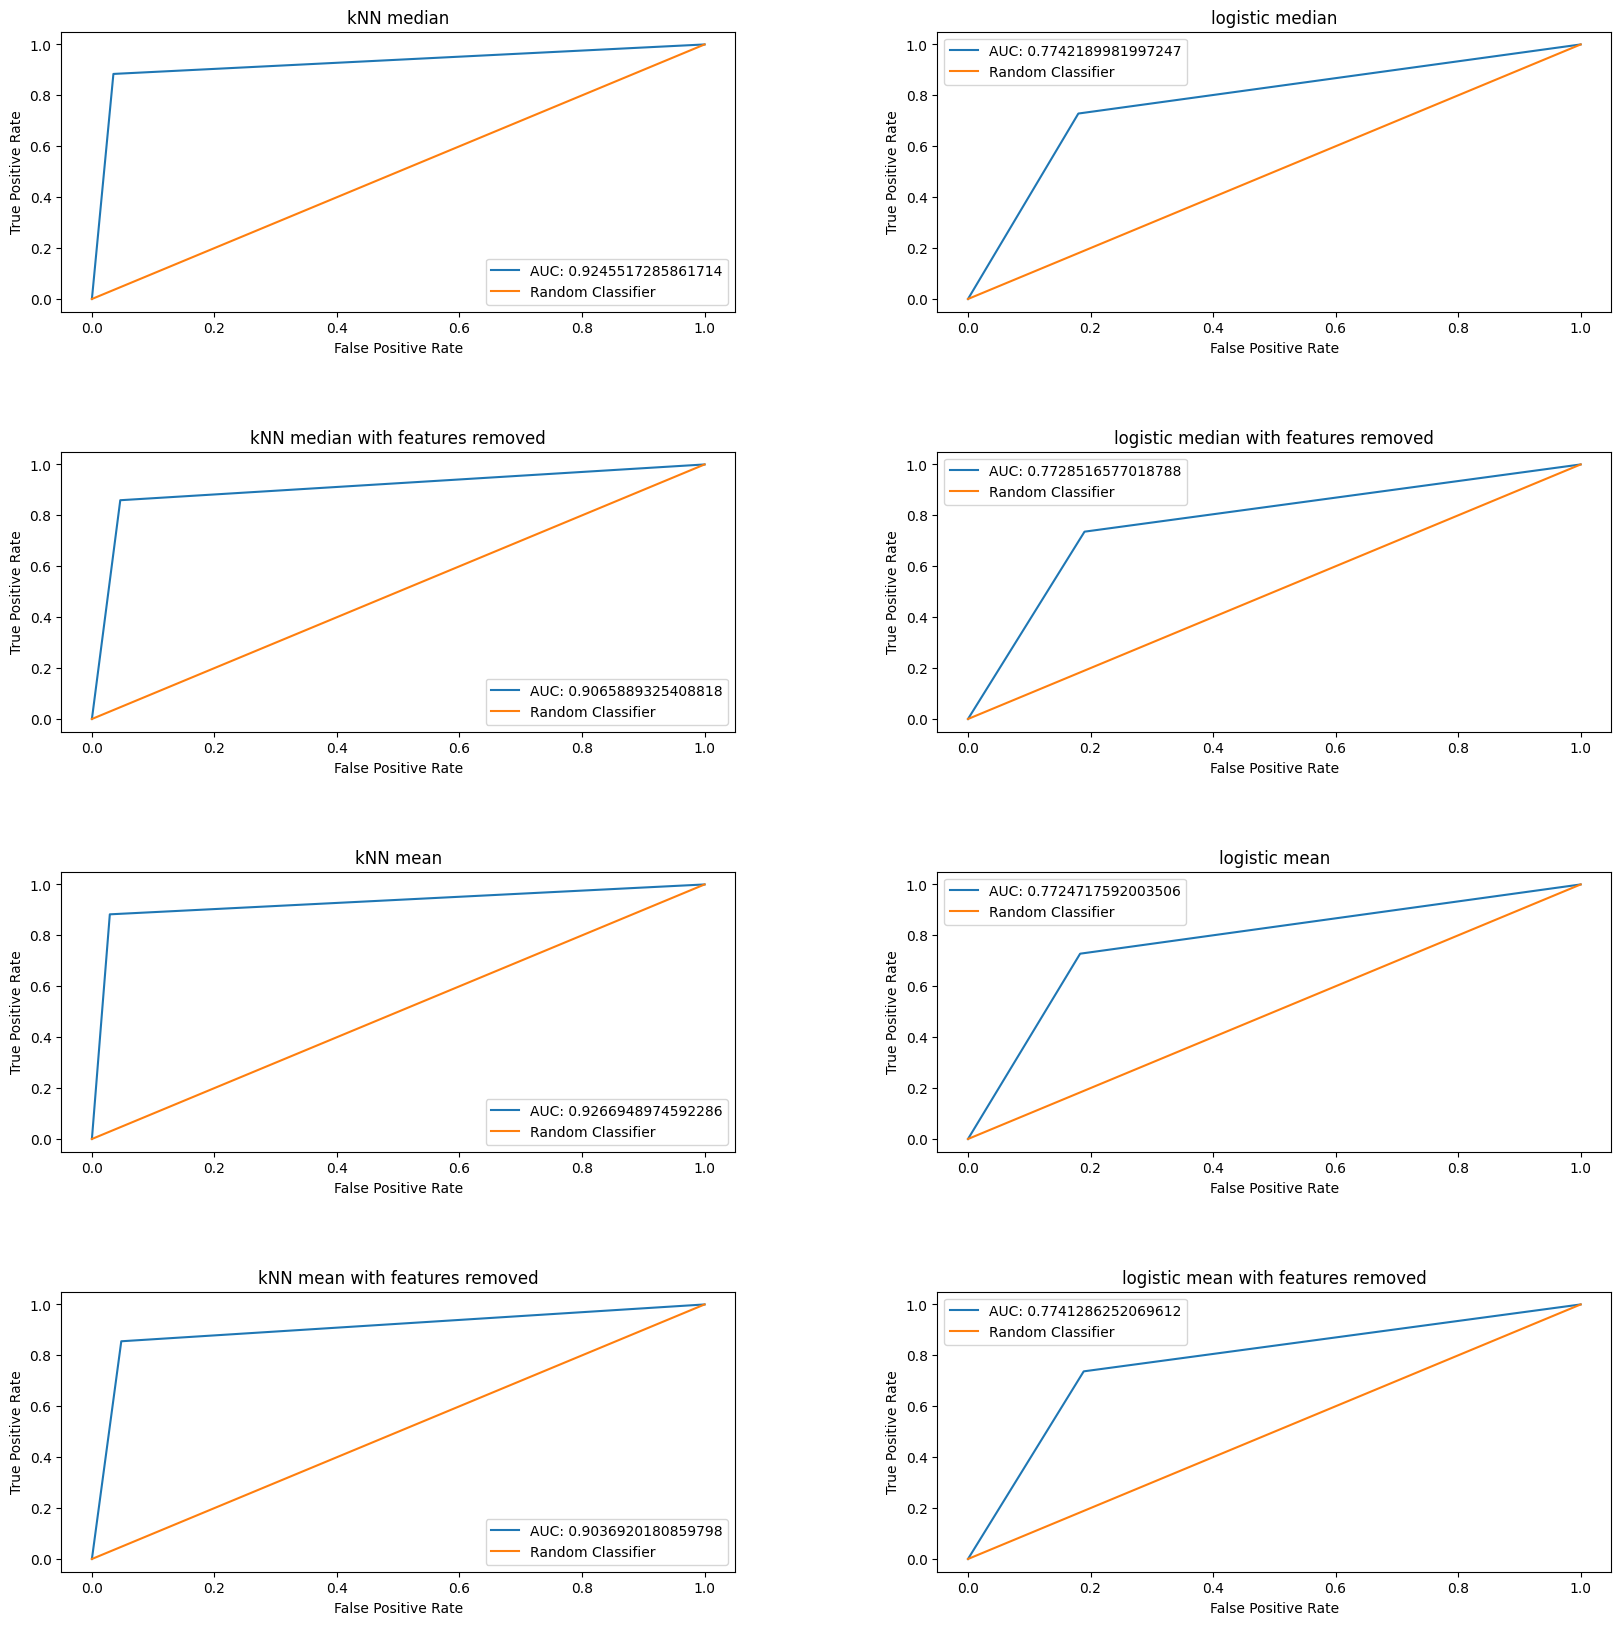

In [38]:
data = {
    "kNN median": [y_pred_median, y_test_median],
    "logistic median": [logistic_y_pred_median, y_test_median],
    "kNN median with features removed": [y_pred_median_removed, y_test_median_removed],
    "logistic median with features removed": [logistic_y_pred_median_removed, y_test_median_removed],
    "kNN mean": [y_pred_mean, y_test_mean],
    "logistic mean": [logistic_y_pred_mean, y_test_mean],
    "kNN mean with features removed": [y_pred_mean_removed, y_test_mean_removed],
    "logistic mean with features removed": [logistic_y_pred_mean_removed, y_test_mean_removed]
}
fig, axes = plt.subplots(4,2, figsize=(20,20))
axes = axes.flatten()
for index, name in enumerate(data):
    ax = axes[index]
    FPR, TPR, thresholds = roc_curve(data[name][0], data[name][1])
    roc_auc = auc(FPR, TPR)
    ax.plot(FPR, TPR, label=f'AUC: {roc_auc}')
    ax.plot([0,1],[0,1], label="Random Classifier")
    ax.legend([f'AUC: {roc_auc}', "Random Classifier"])
    ax.set_title(name)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

**It is quite obvious now that both the median imputation and mean imputation are quite similar and not much difference to be found. Comparing the scores, the median dataset is slightly better than the mean. <br /> For the next reports, the median will be taken as a reference.**

#### Comparsion of the models:
- According to the metrics:
<ul>
    <li>The kNN accuracy score was <b>0.928</b> which was much bigger than the Logistic Regression accuracy, <b>0.780</b>. This indicates that the kNN model was able to more accurately classify the patients with having a stroke or not than the Logistic Regression model.</li>
    <li>the kNN precision score is <b>0.965</b> which is also bigger than the Logistic Regression precision score, <b>0.820</b>. This indicates that the kNN model was able to predict patients having a stroke than the Logistic Regression model.</li>
    <li>the kNN recall score is <b>0.909</b> which is bigger than the Logistic Regression recall score, <b>0.795</b>. With the precisiona and recall higher in kNN than Logistic regression, it is to say that Logistic Regression had more error classifying patients. In healthcare, it can be more beneficial to classify patients as sick rather than classifying sick patients as healthy. It is worth mentioning that also classfiying healthy patients as sick can be less favorable since quite a lot of financial resources and psychological consequences will be followed. That's why, kNN does a better job here in having a low error when classifying the patients. This is verified by the f-1 score of kNN having <b>0.9172</b> and Logistic Regression having <b>0.809</b> since f-1 is the harmonic sum of precision and recall.</li>
    <li>The ROC curve for kNN possess a signficantly higher AUC score than logistic regression with both having 0.924 and 0.774 respecitvely. This suggests that kNN was better distinguishing the positive and negative classes than the Logistic Regression.</li>
    <li>Everything said is also applied to the "median features removed" dataset and all the others.</li>
</ul>

#### Which model performed the best:
- kNN performed much better with our dataset than the Logistic Regression model. This is highly due to the non-linear relationship between the features and the target variable. The kNN model was able to capture the local patterns between the variables which can be ignored by the Logistic Regression model.
- With the scores getting slightly better in the datasets of the removed features, Logistic regression is more suceptible to the curse of dimensionality than kNN which can explain the better performance of kNN.